In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt

## Monte Carlo Markov Chain- Metropolis Hastings Algorithm
### Ben Fox, PSTAT 234

The metropolis hastings algorithm is a markov chain monte carlo (MCMC) method. An MCMC is typically used to obtain a sequence of random samples from a probability distribution where direct sampling is difficult. With this sequence, the distribution can be approximated. 

This algorithm can be viewed in a simple, fun simulation called King Markov's journey.  Suppose there is a king, King Markov, who rules 10 islands. The islands are arranged in a circle (thus each island is in between two other islands) and they are numbered $1...10$. The number of the island denotes its population compared to the other islands (i.e island 10 is 10 times more populous than island 1). King Markov wants to spend time on each island in proportion to its population size; however, doesn't want to plan this all out from the beginning. He wants a simple way to decide every week based off the current island he is on if he should move to one of the adjacent islands. The procedure is as follows:

1. King Markov is on an island. To decide which adjacent island to move to, he flips a coin.
2. If the coin turns up heads, he will decide if he should move to the island clockwise to the current island, and if it is tails, he will decide if he should move to the island counterclockwise. The island the coin dictates is deemed the proposal island. 
3. To decide whether to move to the proposal island, King Markov needs to consider the population of the current island and the proposal island. To do this, he counts out a number of stones that represent the relative population size of the current island, and counts out a number of shells that represent the relative population of the proposal island. For example, if he is on island 4, then he will have 4 stones, and the proposal island is island 3, then he will have 3 shells. 
4. Now, if the number of shells is greater than the number of stones, he always moves to the proposal island. If there are more stones than shells, then he gets rid of the amount of stones equal to the number of shells. Thus, if there are 7 stones and 3 shells, he will get rid of 3 stones, $7-3 = 4$ and have 4 stones and 3 shells. Then he places the remaining stones and shells in a bag and randomly choices one. If it is a stone, he stays on the current island. If it is a shell, he moves to the proposal island. 

This algorithm actually will result in King Markov spending time on each island in proportion to that island's population, and is an example of the metropolis hastings MCMC method. This is demonstrated below:

Text(0.5,1,"King Markov's Journey")

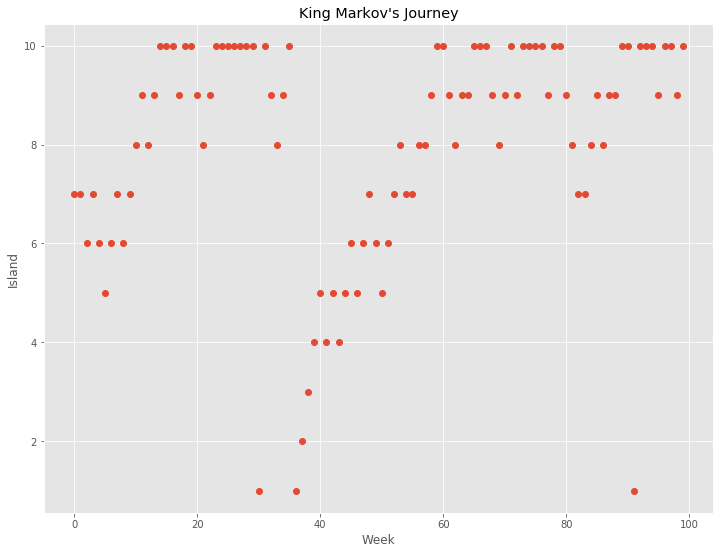

In [2]:
weeks = 10000  # number of weeks
position = [] # list to keep track of position
current = 7 # give an arbitrary starting island
for i in range(weeks):
    position.append(current) # record position
    proposal = current + np.random.choice((-1,1)) # flip coin to decide which adjacent island
    if proposal > 10: # islands are in a circular archipelago
        proposal = 1
    if proposal < 1:
        proposal = 10
    move = proposal/current
    current = proposal if np.random.uniform() < move else current
plt.style.use("ggplot")
plt.figure(figsize = (12,9))
plt.plot(range(0,100), position[0:100], 'o')
plt.xlabel("Week")
plt.ylabel("Island")
plt.title("King Markov's Journey")

As seen above, King Markov is visiting different islands or staying on the same island every week. 

Text(0.5,1,"Distribution of King Markov's Time Spent on Each Island")

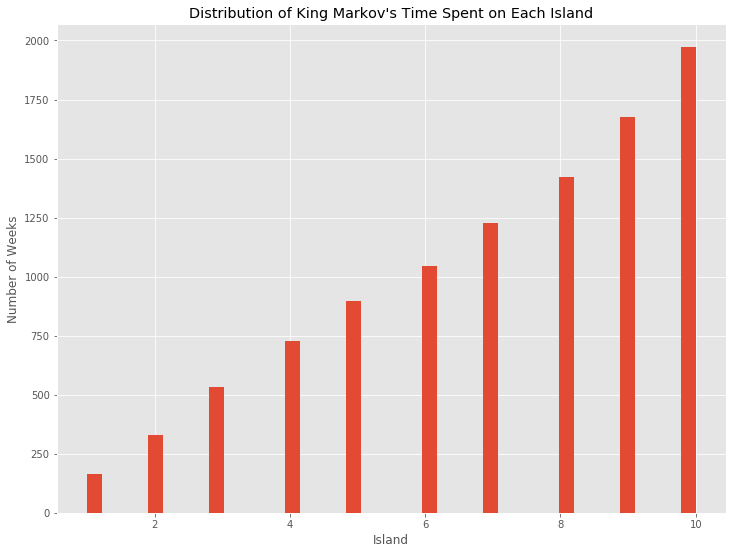

In [3]:
plt.figure(figsize = (12,9))
plt.hist(position, 40)
plt.xlabel("Island")
plt.ylabel("Number of Weeks")
plt.title("Distribution of King Markov's Time Spent on Each Island")

As the distribution shows above, King Markov spent an amount of time proportional to the population size on each island. 

The metropolis hastings algorithm can be more formally introduced through Bayes Theorem. The MCMC is a technique used to determine the posterior distribution. Bayes theorem states:

$$p(\theta|X) =\frac{p(X|\theta)p(\theta)}{p(X)}$$

The posterior distribution is $p(\theta|X)$, the likelihood is $p(X|\theta)$, the prior is $p(\theta)$, and the marginal likelihood is $p(X)$. Now, let's do another simulation example. Suppose we are going to run a simulation of tossing a coin. Typically, coins come up either heads or tails; however, is the probability of landing of heads really 0.5? And is the probability of landing on tails really 0.5? Obviously, there are many factors that could contribute to the probabilities not being equal. 

We can model this using the beta distribution for the prior and posterior pdfs. This is the analytical (the actual) solution.

Text(0.5,1,'Probability Distributions of Flipping a Biased Coin')

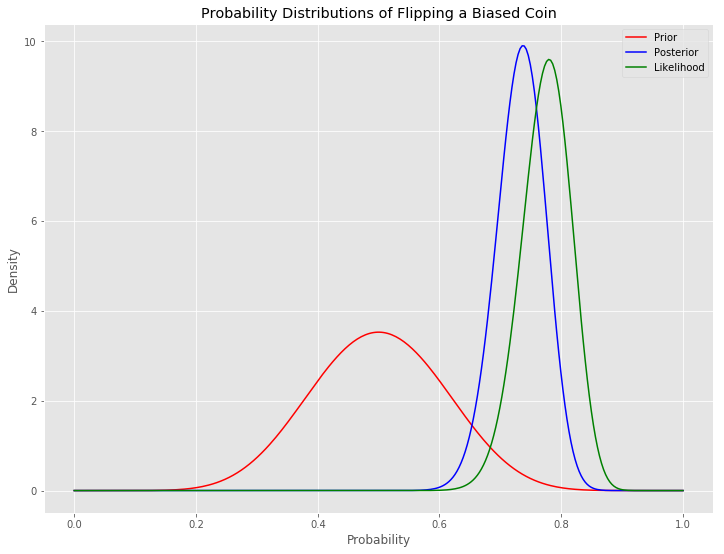

In [4]:
flips = 100 # number of coin flips
heads = 78 # let's say there is a heads bias
a, b = 10, 10 # for beta distribution, assume heads or tails 50/50

prior = st.beta(a,b) 
post = st.beta(heads+a, flips-heads+b) # posterior beta distribution updated with actual
x = np.linspace(0,1,300) # probabilities
like = st.binom(flips,x) # likelihood

plt.figure(figsize = (12,9))
plt.plot(x, prior.pdf(x), label = "Prior", c = "red")
plt.plot(x, post.pdf(x), label = "Posterior", c = "blue")
plt.plot(x, flips*like.pmf(heads), label ="Likelihood", c = "green") # likelihood
plt.legend()
plt.xlabel("Probability")
plt.ylabel("Density")
plt.title("Probability Distributions of Flipping a Biased Coin")


Now, lets see how MCMC can estimate the posterior probability.

The denominator of Bayes theorom $p(X)$, also known as the marginal likelihood is often very difficult to find. It is usually found through a numerical analysis technique or a monte carlo method. The MCMC metropolis hastings algorithm can be used to estimate the posterior distribution without knowing the marginal likelihood using the assumption that posterior $\propto$ likelihood $*$ prior. In the example below, we will estimate the posterior distribution for the same coin example above and compare.

The metropolis hastings algorithm follows a random walk procedure. 
1. We guess a distribution $\theta$ (similar to how we randomly started on an island in King Markov's example, a.k.a the current island). 
2. Next, choose a new proposed value $\theta_n$ such that $\theta_n = \theta +\Delta\theta$ (a.k.a the proposal island) where $\Delta\theta$ is $\mathcal{N}(0,\sigma)$.
3. Calculate the ratio of the two distributions using the prior distributions: $$\rho = \frac{p(X|\theta_n)p(\theta_n)}{p(X|\theta)p(\theta)}$$
4. If $\rho \ge 1$ then set $\theta = \theta_n$. If $\rho \lt 1$ then set $\theta = \theta_n$ with probability $\rho$, else $\theta = \theta$
5. Repeat these steps (hence the walk)

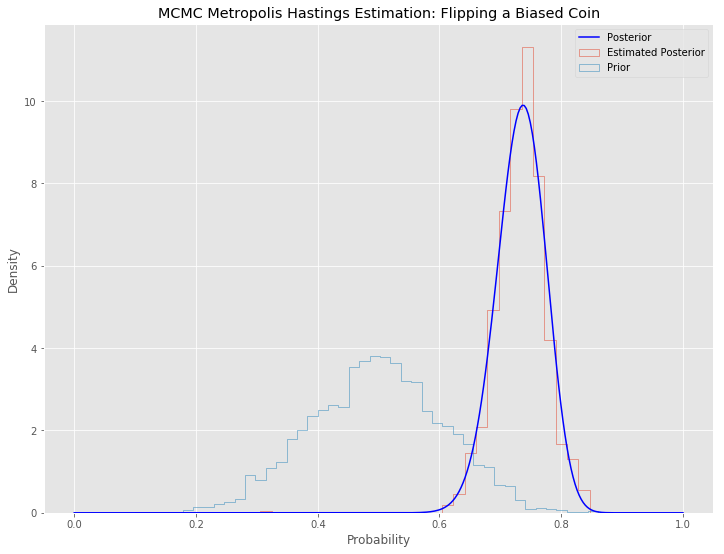

In [5]:
flips = 100  # same as above
heads = 78
a,b = 10,10

prior = st.beta(a,b)  # find prior probability from beta dist.
theta = 0.1  # choose a starting theta
walks = 4000 # how many walks
samples = [] 
sigma = 0.4 # choose a sigma
for i in range(walks):
    samples.append(theta)
    theta_n = theta + np.random.normal(0,sigma)
    if theta < 0:
        theta = 1
    if theta > 1:
        theta = 0
    # calculate rho
    rho = (st.binom(flips, theta_n).pmf(heads) * prior.pdf(theta_n))/(st.binom(flips,theta).pmf(heads) *prior.pdf(theta))
    theta = theta_n if np.random.uniform() < rho else theta
b = len(samples)
plt.figure(figsize = (12,9))
plt.hist(samples, 40, density = True, histtype = "step", label = "Estimated Posterior")
plt.hist(prior.rvs(b), 40, density = True, histtype = "step", label = "Prior")
plt.plot(x, post.pdf(x), label = "Posterior", c = "blue")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.title("MCMC Metropolis Hastings Estimation: Flipping a Biased Coin")
plt.legend()

As seen above, the MCMC metropolis hastings algorithm converged to the actual posterior distribution (in blue). This is a very useful way to estimate the posterior distributions of many other problems where direct sampling cannot be done.